In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

### Воспользуемся датасетом spambase

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data > spambase.data

--2018-12-02 16:38:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702942 (686K) [text/plain]
Saving to: ‘spambase.data.1’

spambase.data.1     100%[===================>] 686,47K   110KB/s    in 6,6s    

2018-12-02 16:38:33 (105 KB/s) - ‘spambase.data.1’ saved [702942/702942]



In [35]:
df = pd.read_csv('spambase.data', names=np.arange(58))

In [36]:
X = df.iloc[:, :57].values
y = df.iloc[:, 57].values

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [40]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

## Часть 1

In [41]:
for p in np.linspace(0, 0.6, 7):
    print(p)

0.0
0.09999999999999999
0.19999999999999998
0.3
0.39999999999999997
0.49999999999999994
0.6


In [42]:
import warnings

In [43]:
warnings.filterwarnings('ignore')

In [45]:
baseline_noise_accuracy = []

for p in np.linspace(0, 0.61, 7):
    
    noise = sps.bernoulli.rvs(size=len(y_train), p=p)
    
    y_train_noise = np.copy(y_train)
    y_train_noise[noise > 0] = 1 - y_train_noise[noise > 0]
    
    noise = sps.bernoulli.rvs(size=len(y_val), p=p)
    y_val_noise = np.copy(y_val)
    y_val_noise[noise > 0] = 1 - y_val_noise[noise > 0]
    
    
    best_acc, best_iterations = 0, 100
    for iterations in [100, 200, 300]:
        clf = CatBoostClassifier(iterations=iterations, depth=4)
        clf.fit(X_train, y_train_noise, verbose=False)
        acc = accuracy_score(y_val_noise, clf.predict(X_val))
        if acc > best_acc:
            best_acc = acc
            best_iterations = iterations
    
    clf = CatBoostClassifier(iterations=best_iterations, depth=4)
    clf.fit(X_train, y_train_noise, verbose=False)    
            
    baseline_noise_accuracy.append((accuracy_score(y_test, clf.predict(X_test)), best_iterations))


In [47]:
baseline_noise_accuracy = np.array(baseline_noise_accuracy)

In [50]:
baseline_noise_accuracy

array([[9.56521739e-01, 1.00000000e+02],
       [9.45652174e-01, 2.00000000e+02],
       [9.41304348e-01, 2.00000000e+02],
       [9.13043478e-01, 2.00000000e+02],
       [8.10869565e-01, 2.00000000e+02],
       [4.00000000e-01, 1.00000000e+02],
       [1.73913043e-01, 1.00000000e+02]])

In [59]:
mask = baseline_noise_accuracy[:, 0] < 0.5
baseline_noise_accuracy[:, 0][mask] = 1 - baseline_noise_accuracy[:, 0][mask]

#### Можно поставить глобальный парметр iterations = 200

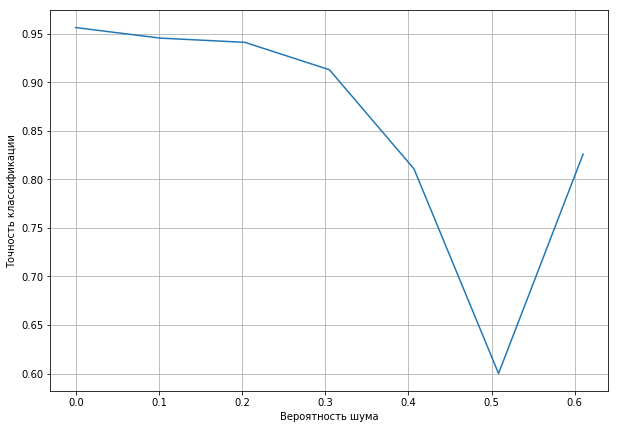

In [60]:
plt.figure(figsize=(10, 7))
plt.plot(np.linspace(0, 0.61, 7), baseline_noise_accuracy[:, 0])
plt.xlabel('Вероятность шума')
plt.ylabel('Точность классификации')
plt.grid()
plt.show()

### Как и ожидалось, шум очень сильно портит качество итоговой модели. Однако небольшой шум (порядка 0.1-0.2) не сказывается критично на обобщающей способности модели

## Часть 2

In [69]:
votes_list = [1, 3, 5, 7, 9, 11]

In [70]:
agg_accuracy = []

for p in np.linspace(0, 0.61, 7):
    
    for votes in votes_list:
        noise = sps.bernoulli.rvs(size=len(y_train) * votes, p=p)
        y_train_noise = np.tile(np.copy(y_train), votes)
        mask = noise > 0
        y_train_noise[mask] = 1 - y_train_noise[mask]
        y_train_noise = y_train_noise.reshape((votes, len(y_train))).T
        y_train_noise = np.median(y_train_noise, axis=1)
        
#         noise = sps.bernoulli.rvs(size=len(y_val), p=p)
#         y_val_noise = np.copy(y_val)
#         y_val_noise[noise > 0] = 1 - y_val_noise[noise > 0]

        clf = CatBoostClassifier(iterations=200, depth=4)
        clf.fit(X_train, y_train_noise, verbose=False)    
            
        agg_accuracy.append((accuracy_score(y_test, clf.predict(X_test)), votes))


In [71]:
grid = np.linspace(0, 0.61, 7)
agg_accuracy = np.array(agg_accuracy)

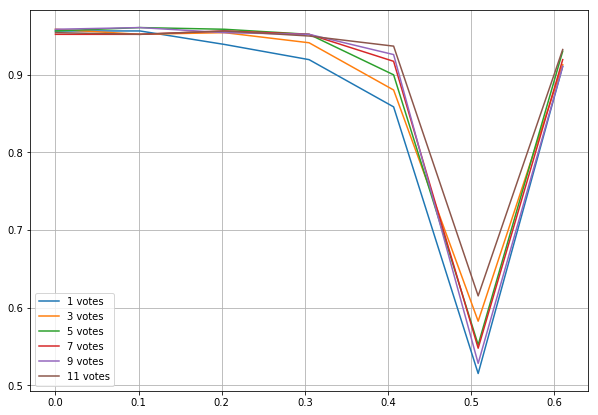

In [72]:
plt.figure(figsize=(10, 7))

for vote in votes_list:
    sub_array = np.copy(agg_accuracy[agg_accuracy[:, 1] == vote][:, 0])
    sub_array[sub_array < 0.5] = 1 - sub_array[sub_array < 0.5]
    plt.plot(grid, sub_array, label=str(vote) + ' votes')

plt.grid()
plt.legend()
plt.show()

### Вывод:
Наилучший прирост по качеству в в отношении числа оценок дают перекрытия 3 и 5.  

## Часть 3

In [ ]:
def dawid_skene(X_votes, num_classes=2):
    Yc = np.median(X_votes, axis=1)
    
    P_ca__Y_q_c = np.zeros(X_votes.shape)
    S_a_c = np.zeros((X_votes.shape[1], num_classes))
    
    
    
    def m_step():
        for j in np.arange(X_votes.shape[1]):
            S_a_c[j] = np.bincount(X_votes[:, j], minlength=num_classes)
        
    

In [54]:
a = np.arange(8)
np.median(np.tile(a, 3).reshape(3, 8).T, axis=1)

array([0., 1., 2., 3., 4., 5., 6., 7.])